# 1. Функция stitch_images: 
Это первый метод для склеивания двух изображений вместе.
   
# 2. Функция draw_matches: 
Эта функция используется для отображения соответствующих точек между двумя изображениями.
   
# 3. Функция warpImages: 
Эта функция отвечает за перспективное преобразование, чтобы два изображения могли правильно склеиваться вместе.


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(img1, img2, MIN, ratio):
    # 统一图像大小Унификация размеров изображений
    height1 = int(img1.shape[0])
    width1 = int(img1.shape[1])
    dim = (width1, height1)
    img2 = cv.resize(img2, dim, interpolation=cv.INTER_AREA)

    # 创建SIFT特征点检测Создание обнаружения точек признаков SIFT
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 使用OpenCV中的FLANN匹配算法进行特征匹配Выполнение сопоставления признаков с использованием алгоритма FLANN в OpenCV
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 储存优质匹配点对Сохранение высококачественных пар сопоставленных точек
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)

    # 计算单应性矩阵Расчет матрицы гомографии
    if len(good) > MIN:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

        # 透视变换Перспективное преобразование
        warpimg = cv.warpPerspective(img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img2.shape[0]))

        # 拼接图像Склеивание изображений
        direct = warpimg.copy()
        direct[0:img1.shape[0], 0:img1.shape[1]] = img1
        rows, cols = img1.shape[:2]

        # 找到重叠边界Найти границы перекрытия
        left = 0
        right = cols
        for col in range(0, cols):
            if img1[:, col].any() and warpimg[:, col].any():
                left = col
                break
        for col in range(cols - 1, 0, -1):
            if img1[:, col].any() and warpimg[:, col].any():
                right = col
                break

        #图像融合 Слияние изображений
        res = np.zeros([rows, cols, 3], np.uint8)
        for row in range(0, rows):
            for col in range(0, cols):
                if not img1[row, col].any():
                    res[row, col] = warpimg[row, col]
                elif not warpimg[row, col].any():
                    res[row, col] = img1[row, col]
                else:
                    srcimgLen = float(abs(col - left))
                    testimgLen = float(abs(col - right))
                    alpha = srcimgLen / (srcimgLen + testimgLen)
                    res[row, col] = np.clip(img1[row, col] * (1 - alpha) + warpimg[row, col] * alpha, 0, 255)

        warpimg[0:img1.shape[0], 0:img1.shape[1]] = res

        # 重新校准图像尺寸Перекалибровка размера изображения
        warpimg = cv.resize(warpimg, (img1.shape[1], img1.shape[0]), interpolation=cv.INTER_AREA)

        return warpimg
    
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r1, c1 = img1.shape[:2]
  r2, c2 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r1, r2]), c1+c2, 3), dtype='uint8')
  output_img[:r1, :c1, :] = img1 #np.dstack([img1, img1, img1])
  output_img[:r2, c1:c1+c2, :] = img2 #np.dstack([img2, img2, img2])

  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv.circle(output_img, (int(x1),int(y1)), 1, (0, 255, 255), 1)
    cv.circle(output_img, (int(x2)+c1,int(y2)), 1, (0, 255, 255), 1)

    # Connect the same keypoints
    cv.line(output_img, (int(x1),int(y1)), (int(x2)+c1,int(y2)), (0, 255, 255), 1)

  return output_img

def warpImages(img1, img2, H):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min, -y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img


#Чтение изображений
path_img1 = r"D:\Projects\Pycharm_projects\CV\task3\building2\dsc_2705.jpg"
path_img2 = r"D:\Projects\Pycharm_projects\CV\task3\building2\dsc_2706.jpg"
path_img3 = r"D:\Projects\Pycharm_projects\CV\task3\building2\dsc_2707.jpg"
path_img4 = r"D:\Projects\Pycharm_projects\CV\task3\building2\dsc_2708.jpg"

img1 = cv.imread(path_img1)
img2 = cv.imread(path_img2)
img3 = cv.imread(path_img3)
img4 = cv.imread(path_img4)


# Используя первый метод сшивания изображений (функция stitch_images), сшейте вместе рисунки 1 и 2 слева и рисунки 3 и 4

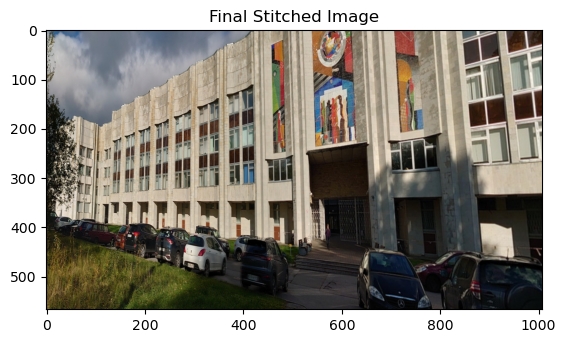

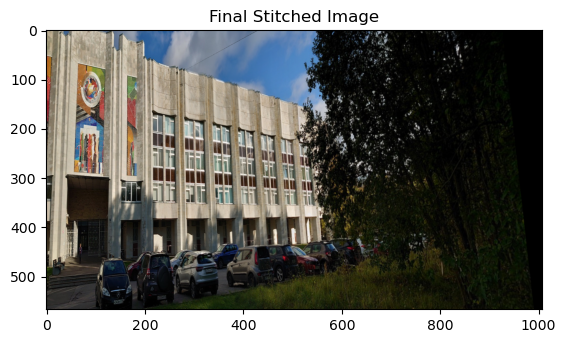

In [2]:
image12 = stitch_images(img1, img2, MIN=10, ratio=0.6)
#plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(image12, cv.COLOR_BGR2RGB))
plt.title('Final Stitched Image')
plt.show()

image34 = stitch_images(img3, img4, MIN=10, ratio=0.6)
#plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(image34, cv.COLOR_BGR2RGB))
plt.title('Final Stitched Image')
plt.show()

# Заливка границ для двух изображений

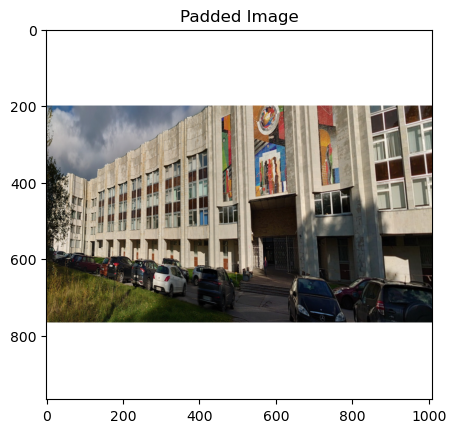

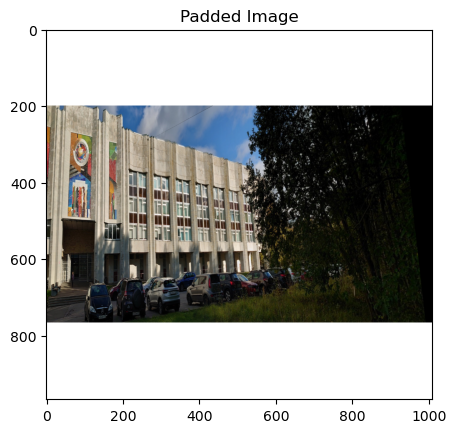

In [4]:
# 复制图像以避免修改原始图像
img = image12.copy()
imgg = image34.copy()
# 定义边界填充参数
top, bottom, left, right = 200,200,0,0
border_type = cv.BORDER_CONSTANT # 边界填充类型
value = [255, 255, 255]  # 边界填充的颜色值（白色）

# 进行边界填充
img= cv.copyMakeBorder(img, top, bottom, left, right, border_type, value=value)
imgg= cv.copyMakeBorder(imgg, top, bottom, left, right, border_type, value=value)
# 显示结果
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.title('Padded Image')
plt.show()
plt.imshow(cv.cvtColor(imgg,cv.COLOR_BGR2RGB))
plt.title('Padded Image')
plt.show()

# Выполните преобразование перспективы на левой стороне сращивания.

Selected points:
Point 1: [  2. 193.]
Point 2: [1002.    2.]
Point 3: [1004.  963.]
Point 4: [  6. 771.]
Homography Matrix:
[[ 1.66116306e+00 -1.14959381e-02 -1.10361006e+00]
 [ 1.64464282e-01  8.61069540e-01 -1.66515350e+02]
 [ 6.62053510e-04 -9.41662585e-06  1.00000000e+00]]


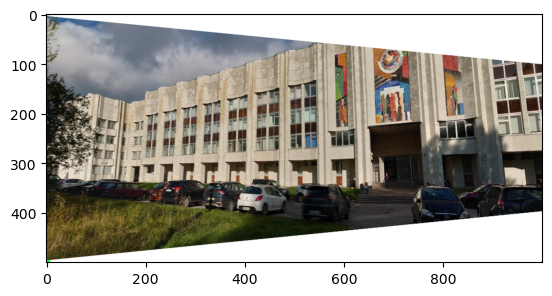

In [5]:
import cv2 as cv
import numpy as np

# 全局变量
points = []
def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(img, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', img)
# 创建窗口并设置鼠标回调
cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', img)
cv.waitKey(0)
cv.destroyAllWindows()

# 确保选择了四个点
if len(points) != 4:
    raise ValueError("You must select exactly 4 points.")
points = np.array(points, dtype=np.float32)

# 确认点的选择顺序
print("Selected points:")
for i, point in enumerate(points):
    print(f"Point {i+1}: {point}")

# 定义目标点
width, height =1000,500# 目标图像的宽度和高度
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

# 计算单应性矩阵
M, _ = cv.findHomography(points, dst_points)
print("Homography Matrix:")
print(M)

# 应用透视变换
result1 = cv.warpPerspective(img, M, (width, height))
plt.imshow(cv.cvtColor(result1,cv.COLOR_BGR2RGB))
plt.show()

# Выполните преобразование перспективы на правой стороне сращивания.

Selected points:
Point 1: [1. 0.]
Point 2: [1003.  195.]
Point 3: [1002.  777.]
Point 4: [  3. 962.]
Homography Matrix:
[[ 6.03364080e-01 -1.25439518e-03 -6.03364080e-01]
 [-1.00781502e-01  5.17861870e-01  1.00781502e-01]
 [-3.93913312e-04 -2.96793022e-06  1.00000000e+00]]


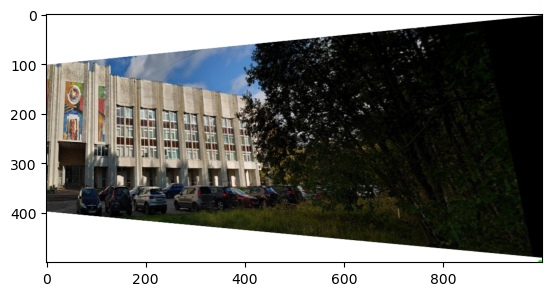

In [6]:
import cv2 as cv
import numpy as np

# 全局变量
points = []
def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(imgg, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', imgg)
# 创建窗口并设置鼠标回调
cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', imgg)
cv.waitKey(0)
cv.destroyAllWindows()

# 确保选择了四个点
if len(points) != 4:
    raise ValueError("You must select exactly 4 points.")
points = np.array(points, dtype=np.float32)

# 确认点的选择顺序
print("Selected points:")
for i, point in enumerate(points):
    print(f"Point {i+1}: {point}")

# 定义目标点
width, height =1000,500# 目标图像的宽度和高度
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

# 计算单应性矩阵
M, _ = cv.findHomography(points, dst_points)
print("Homography Matrix:")
print(M)

# 应用透视变换
result2 = cv.warpPerspective(imgg, M, (width, height))
plt.imshow(cv.cvtColor(result2,cv.COLOR_BGR2RGB))
plt.show()

# Использование второго метода сшивания изображений

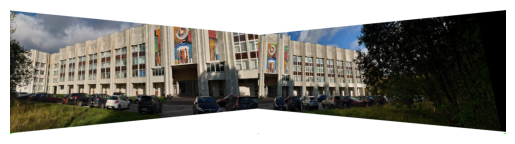

In [7]:
img12=result1.copy()
img34=result2.copy()
# 获取图片尺寸
h1, w1 = img12.shape[:2]
h2, w2 = img34.shape[:2]

high=int(max(h1,h2))
# 调整图片尺寸
img12 = cv.resize(img12, (w1, high))
img34 = cv.resize(img34 ,(w2, high))

# 水平拼接图片
concatenated_image = np.concatenate(( img12,img34), axis=1)

plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()

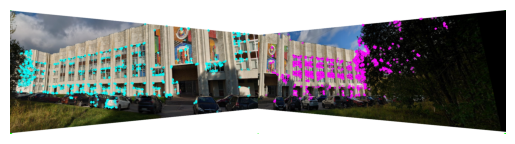

In [8]:
orb = cv.ORB_create(nfeatures=2000)
keypoints2, descriptors2 = orb.detectAndCompute(img12, None)
keypoints3, descriptors3 = orb.detectAndCompute(img34, None)
img2_kp = cv.drawKeypoints(img12, keypoints2, None, (255, 255, 0))
img3_kp = cv.drawKeypoints(img34, keypoints3, None, (255, 0, 255))
concatenated_image = np.concatenate(( img2_kp,img3_kp), axis=1)
plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()

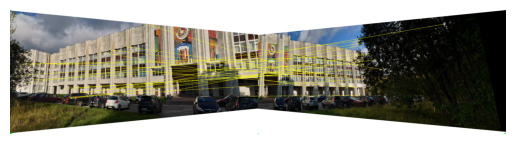

In [9]:
bf = cv.BFMatcher_create(cv.NORM_HAMMING)
matches23 = bf.knnMatch(descriptors2, descriptors3, k=2)
all_matches23 = []
for m, n in matches23:
  all_matches23.append(m)

img23= draw_matches(img12, keypoints2, img34, keypoints3, all_matches23[:30])
plt.imshow(cv.cvtColor(img23, cv.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()

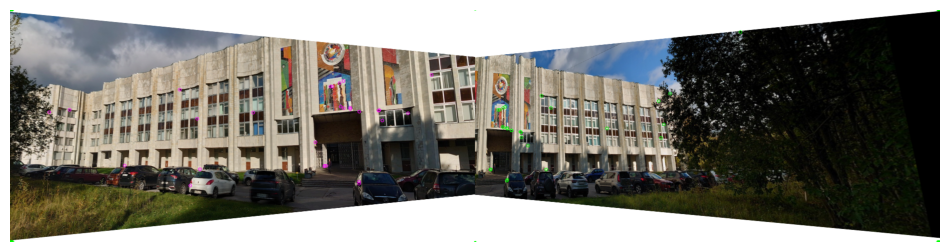

In [15]:
good23 = []
for m, n in matches23:
    if m.distance < 0.75 * n.distance:
        good23.append(m)

img2_kp = cv.drawKeypoints(img12, [keypoints2[m.queryIdx] for m in good23], None, (255, 0, 255))
img3_kp = cv.drawKeypoints(img34, [keypoints3[m.trainIdx] for m in good23], None, (0, 255, 0))
concatenated_image = np.concatenate(( img2_kp,img3_kp), axis=1)
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))

plt.axis('off')  # 关闭坐标轴
plt.show()


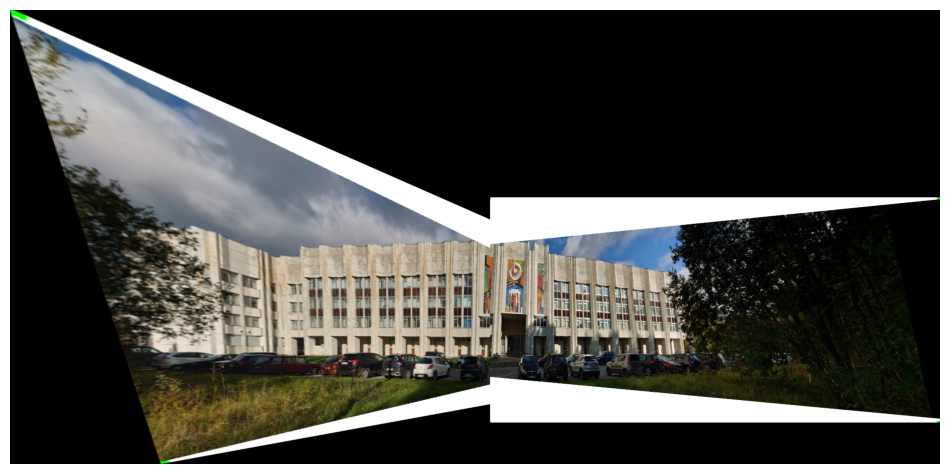

In [17]:
MIN_MATCH_COUNT = 10 # Set minimum match condition

if len(good23) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints2[m.queryIdx].pt for m in good23]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints3[m.trainIdx].pt for m in good23]).reshape(-1,1,2)

    # Вычисление матрицы гомографии
    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC,2)
    img23 = warpImages(img34, img12, M)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv.cvtColor(img23, cv.COLOR_BGR2RGB))
    plt.axis('off')  # 关闭坐标轴
    plt.show()


# Выполните вырезание многоугольников

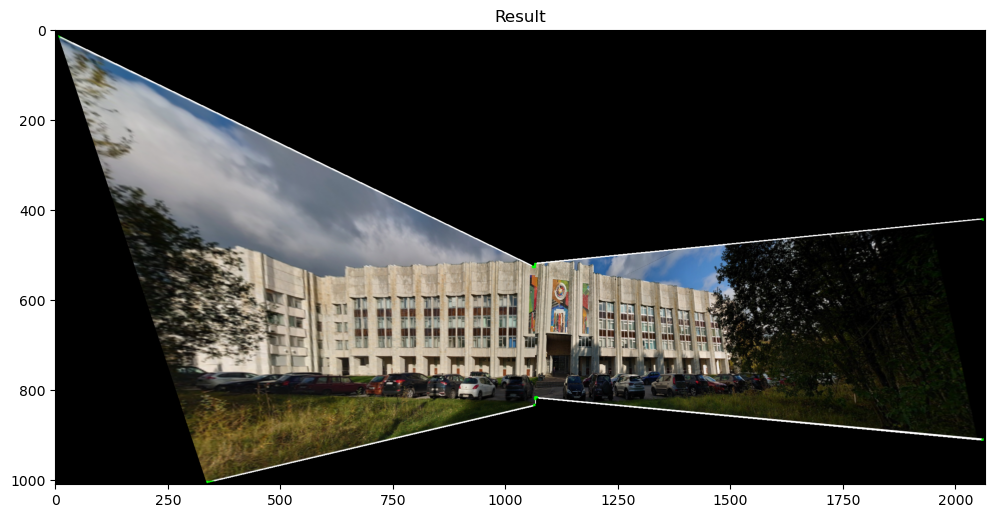

In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# 复制图像以避免修改原始图像
result = img23.copy()
def select_points(event, x, y, flags, param):
    global points
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        cv.circle(result, (x, y), 5, (0, 255, 0), -1)
        cv.imshow('image', result)
# 定义全局变量
points = []
# 创建窗口并设置鼠标回调
cv.namedWindow('image')
cv.setMouseCallback('image', select_points)
cv.imshow('image', result)
cv.waitKey(0)
cv.destroyAllWindows()

# 确保选择了六个点
if len(points) != 8:
    raise ValueError("You must select exactly 6 points.")
points = np.array(points, dtype=np.int32)

# 创建掩码并进行多边形裁剪
mask = np.zeros_like(result)
cv.fillPoly(mask, [points], (255, 255, 255))

# 确保 result 和 mask 的尺寸和类型一致
if result.shape != mask.shape:
    raise ValueError("The dimensions of result and mask do not match.")

# 进行位运算
masked_image = cv.bitwise_and(result, mask)
plt.figure(figsize=(12, 6))

# 显示结果
plt.imshow(cv.cvtColor(masked_image, cv.COLOR_BGR2RGB))
plt.title('Result')
plt.show()